In [1]:
"""Import Statements"""
import json
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
def load_from_json(path: str):
    """Load a JSON object from a file into a variable"""

    with open(path, mode='r', encoding="utf-8") as json_file:
        res = json.load(json_file)
    return res

In [3]:
DIRECTORY_PATH = 'tspset1'

# Get a list of filenames in the directory (excluding subdirectories)
filenames = [filename for filename in os.listdir(DIRECTORY_PATH)
             if os.path.isfile(os.path.join(DIRECTORY_PATH, filename))]

# Sort filenames
filenames.sort(key = lambda name: int(name.replace('tsp_', '').replace('_sol.json','')))

# Read optimal tour lengths from JSON files
opt = []
for filename in filenames:
    opt.append(load_from_json(DIRECTORY_PATH + '/' + filename)['tourlength'])

In [4]:
DIRECTORY_PATH = 'json/'

# Get filenames of heuristics and approximation results
heuristics = {}
filenames = [filename for filename in os.listdir(DIRECTORY_PATH)
             if os.path.isfile(os.path.join(DIRECTORY_PATH, filename))]

for filename in filenames:
    heuristics[filename.replace('.json', '')] = np.array(load_from_json(DIRECTORY_PATH + filename))


In [5]:
# Abbreviation dict for heuristics
heuristic_names = {
    'ni': 'Nearest Insertion',
    'opt': 'Optimal Tourlength',
    'nn': 'Nearest Neighbor',
    'ri': 'Random Insertion',
    'mstheu': 'Minimum Spanning Tree Heuristic',
    'mst': 'Minimum Spanning Tree',
    'lplb': 'LP Relaxation',
    'greedy': 'Greedy Heuristic',
    'fi': 'Farthest Insertion',
    'ci': 'Cheapest Insertion',
    'christo': 'Christofides Heuristik',
    'assrel': 'Assignment Relaxation',
    '1tree': '1 Tree'
}
custom_cmap = {
    0: 'blue',
    1: 'orange',
    2: 'green',
    3: 'red',
    4: 'purple',
    5: 'brown',
    6: 'pink',
    7: 'gray',
    8: 'olive',
    9: 'cyan',
    10: 'black',
    11: 'lawngreen'
}

In [19]:
def heuristics_hist_matrix(plot_data: dict):
    """Print A matrix of histograms that decribe given heuristics"""

    # Get the number of rows and columns for the matrix
    num_rows = 3
    num_cols = 4

    # Create a figure and subplots
    axs = plt.subplots(num_rows, num_cols, figsize=(24, 12))[1]

    # Flatten the axs array to iterate through it easily
    axs = axs.flatten()

    # Iterate over the dictionary and plot histograms
    for i, (array_name, array_data) in enumerate(plot_data.items()):
        axs[i].hist(array_data, bins=20, color = custom_cmap[i], alpha=0.4)
        axs[i].set_title(heuristic_names[array_name])
        axs[i].grid(True)

    # Adjust layout for better spacing
    plt.tight_layout()


    # Show the plot
    plt.show()

## Histograms of Heuristics

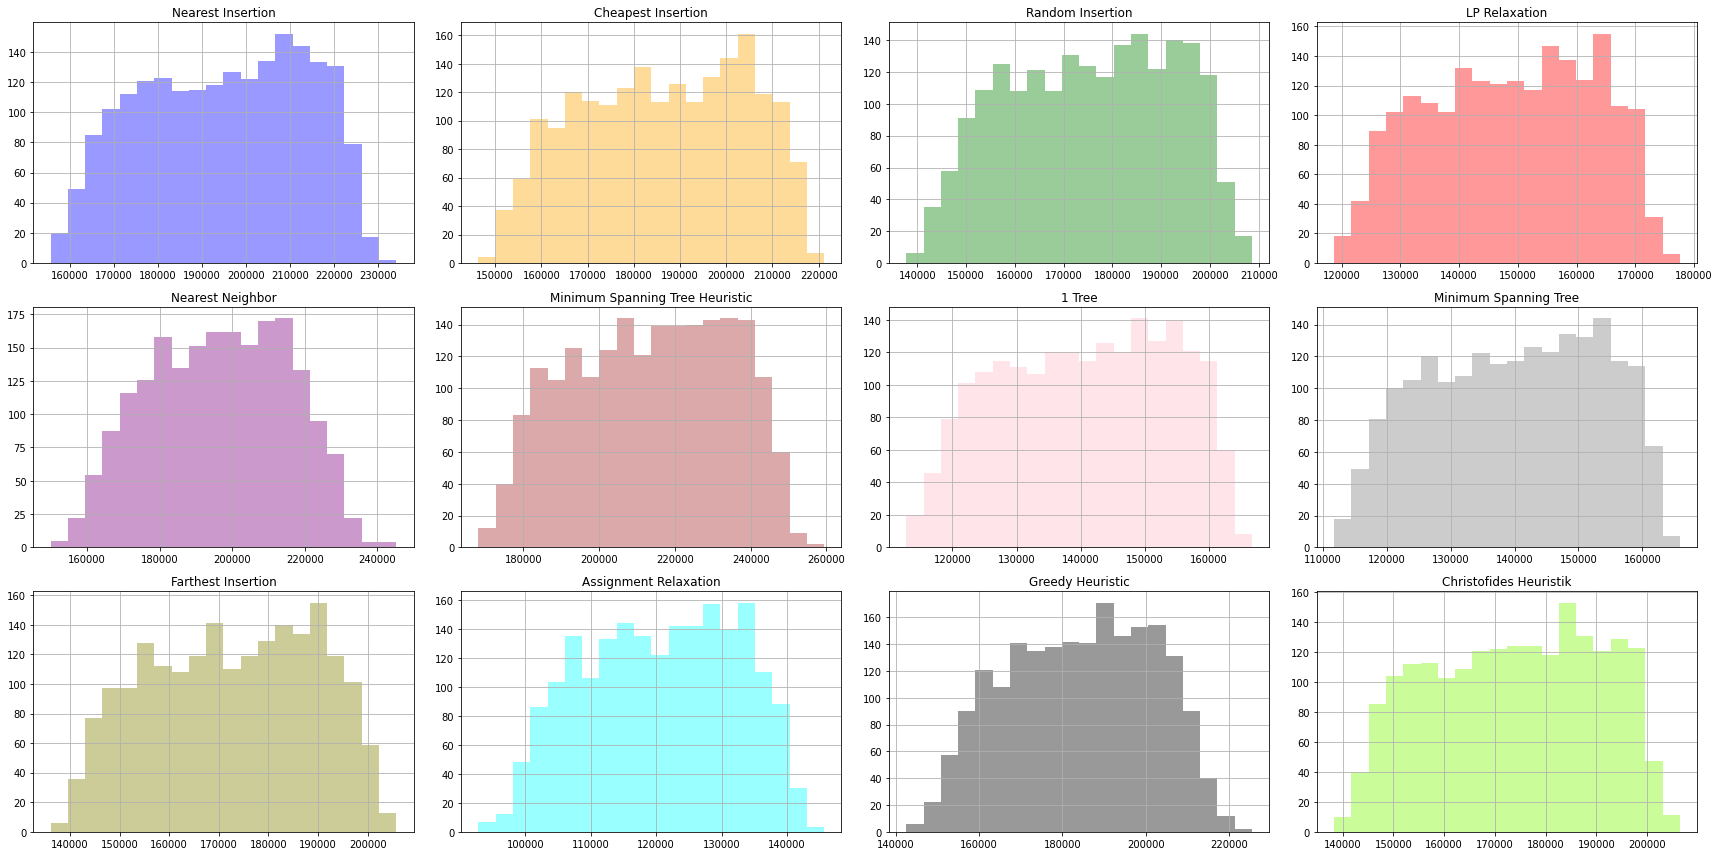

In [7]:
heuristics_without_opt = heuristics.copy()
del heuristics_without_opt['opt']
heuristics_hist_matrix(heuristics_without_opt)

## Histograms of Accuracy of Heuristics in Relation to optimal TSP-Tour

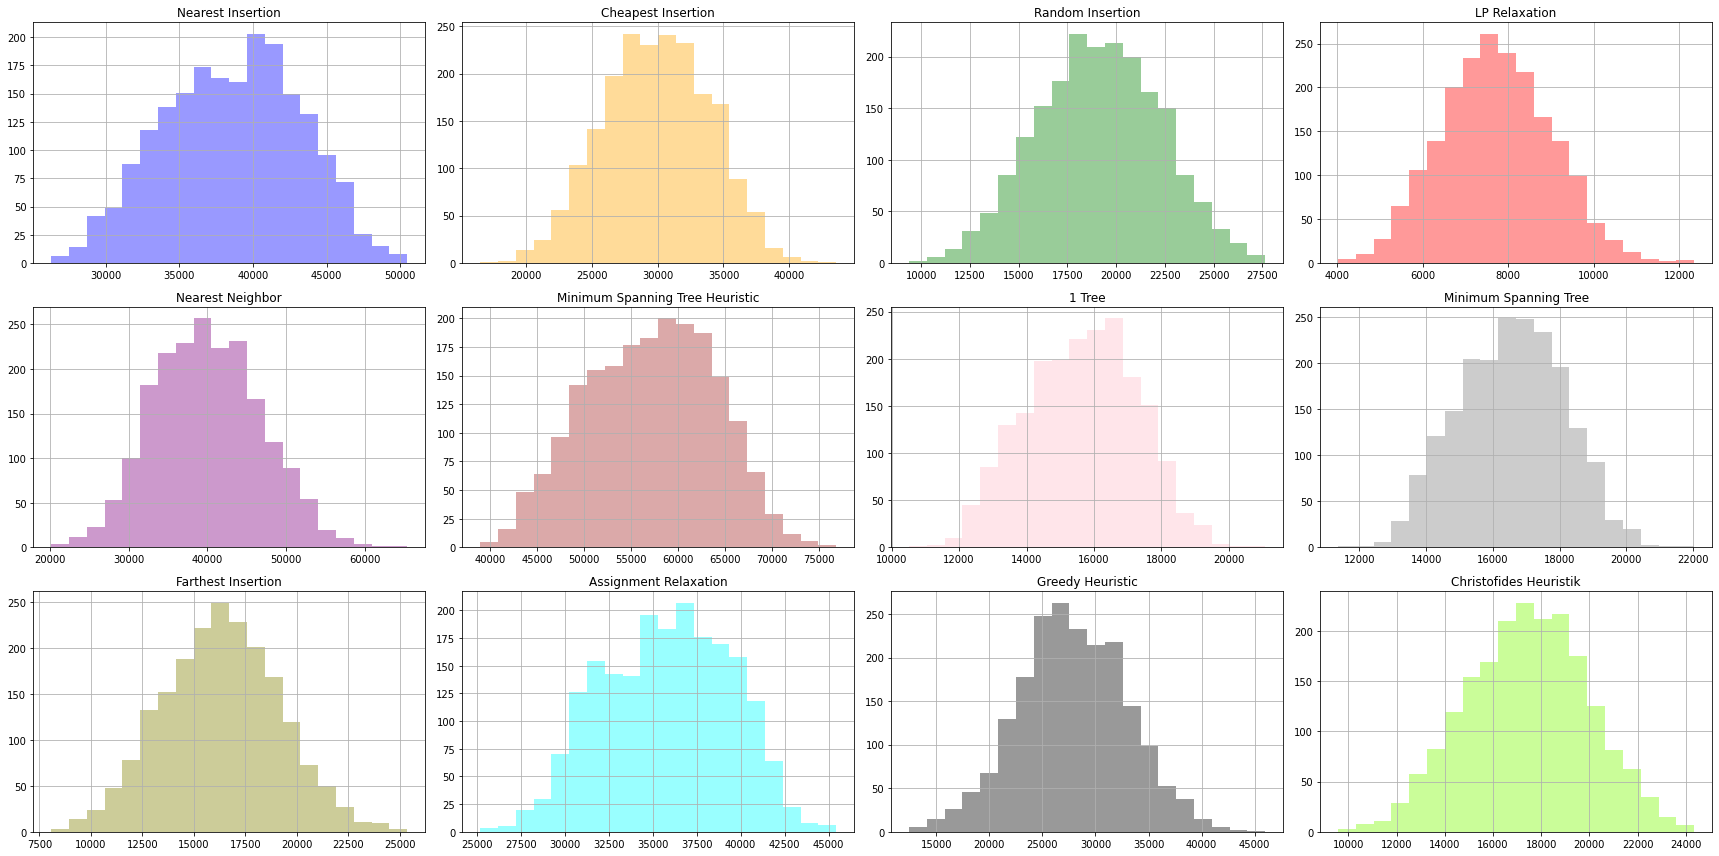

In [8]:
# Find difference of the heuristics to the optimal tour length
distances_from_opt = {}
for key, value in heuristics.items():
    if key == 'opt':
        continue
    distances_from_opt[key] = abs(heuristics['opt'] - value)

heuristics_hist_matrix(distances_from_opt)

## Percentual deviation from optimal tour costs
Note that here negative values indicate that the heuristic is a lower bound while positive values indicate a heuristic to be an approximatio of the problem solution

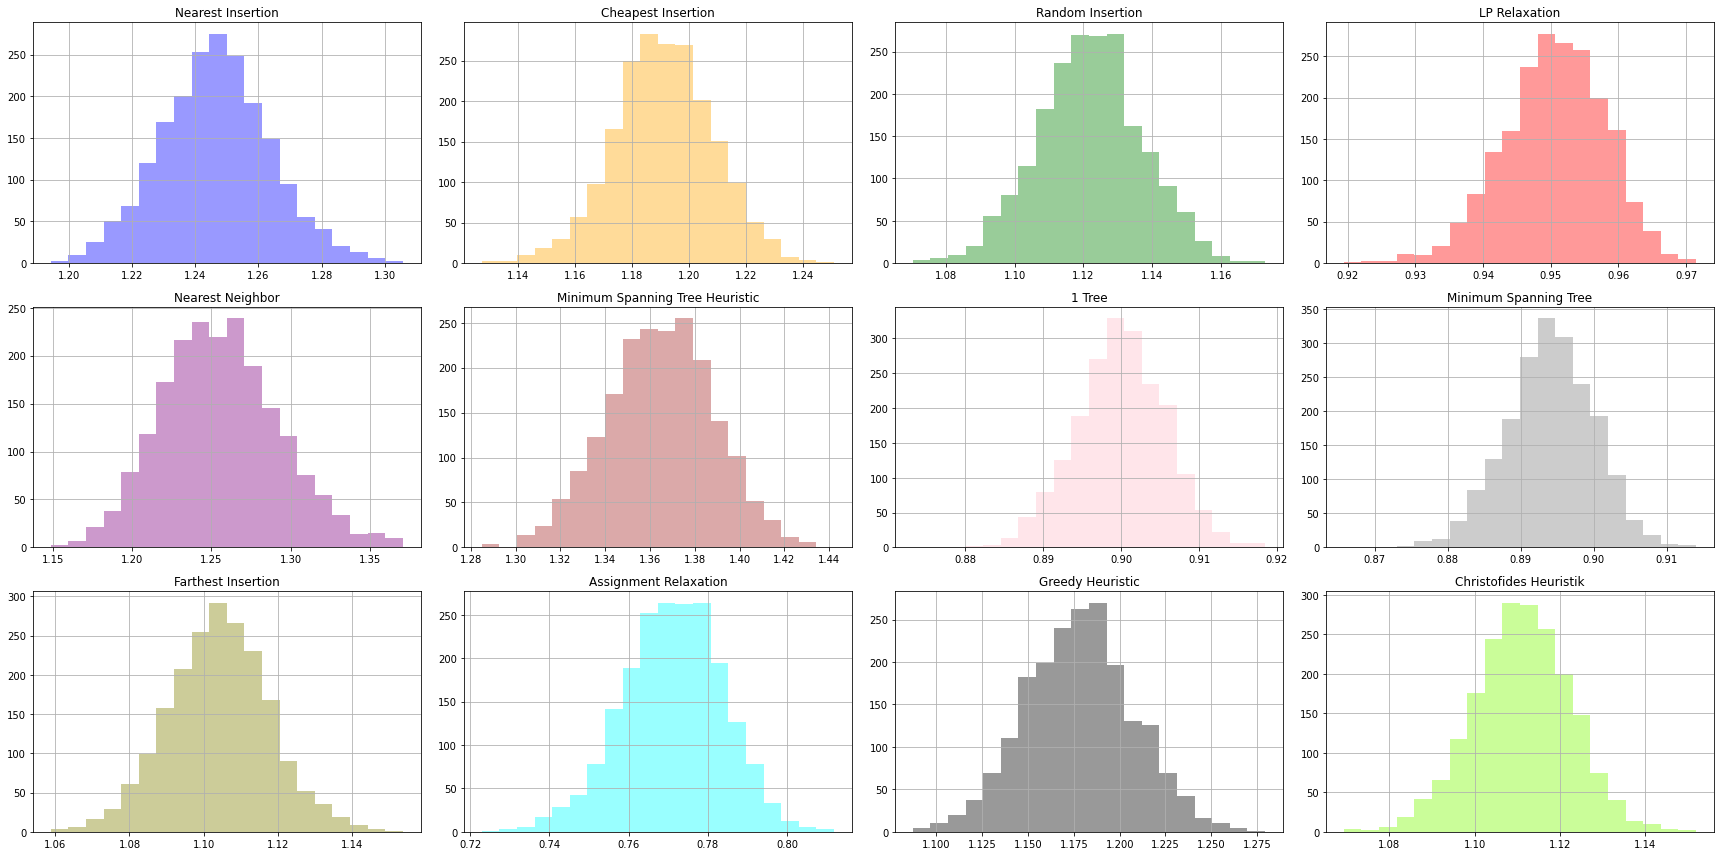

In [9]:
perc_dev_from_opt = {}
for key, value in heuristics.items():
    if key == 'opt':
        continue
    distance = heuristics['opt'] - value
    rel_distance = distance / heuristics['opt']
    perc_dev_from_opt[key] = 1 - rel_distance

heuristics_hist_matrix(perc_dev_from_opt)

In [10]:
devs = {}
for key, value in perc_dev_from_opt.items():
    display_name = heuristic_names[key]
    devs[display_name] = []
    devs[display_name].append(np.median(value))
    devs[display_name].append(np.mean(value))


df = pd.DataFrame(data=devs, index=['Median', 'Mean'])
print(df.T)

                                   Median      Mean
Nearest Insertion                1.246618  1.246526
Cheapest Insertion               1.191330  1.191171
Random Insertion                 1.121979  1.121880
LP Relaxation                    0.950794  0.950505
Nearest Neighbor                 1.254825  1.255869
Minimum Spanning Tree Heuristic  1.365463  1.364788
1 Tree                           0.899955  0.899949
Minimum Spanning Tree            0.894225  0.894054
Farthest Insertion               1.104330  1.104064
Assignment Relaxation            0.771522  0.771156
Greedy Heuristic                 1.178439  1.178128
Christofides Heuristik           1.111340  1.111159


## Visualize a Tour

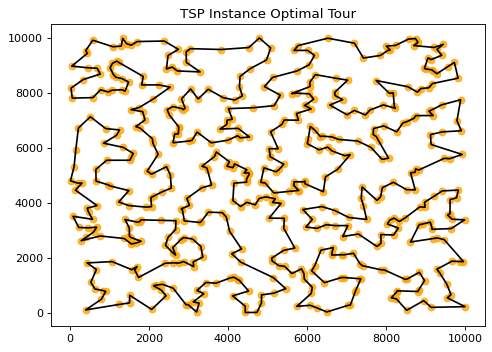

In [11]:
instance = load_from_json('tspset1/tsp_300_sol.json')

coordinates = np.array(instance['node_coordinates'])
tour = np.array([coordinates[step] for step in instance['tour']+[0]])

plt.figure(figsize =(7, 5), dpi=80)
plt.scatter(*coordinates.T, alpha=0.8, color='orange')
plt.plot(*tour.T, color='black')
plt.title('TSP Instance Optimal Tour')
plt.plot()
plt.show()

## Calculating the multiple linear regression

In [12]:
DIRECTORY_PATH = 'tspset1'

# Get a list of filenames in the directory (excluding subdirectories)
filenames = [filename for filename in os.listdir(DIRECTORY_PATH)
             if os.path.isfile(os.path.join(DIRECTORY_PATH, filename))]

# Sort filenames
filenames.sort(key = lambda name: int(name.replace('tsp_', '').replace('_sol.json','')))

# Read data into memory
instances = []
for filename in filenames:
    instance = load_from_json(DIRECTORY_PATH + '/' + filename)
    instances.append(instance)

In [13]:
# delete illegal heuristics
del heuristics['assrel']
del heuristics['ci']

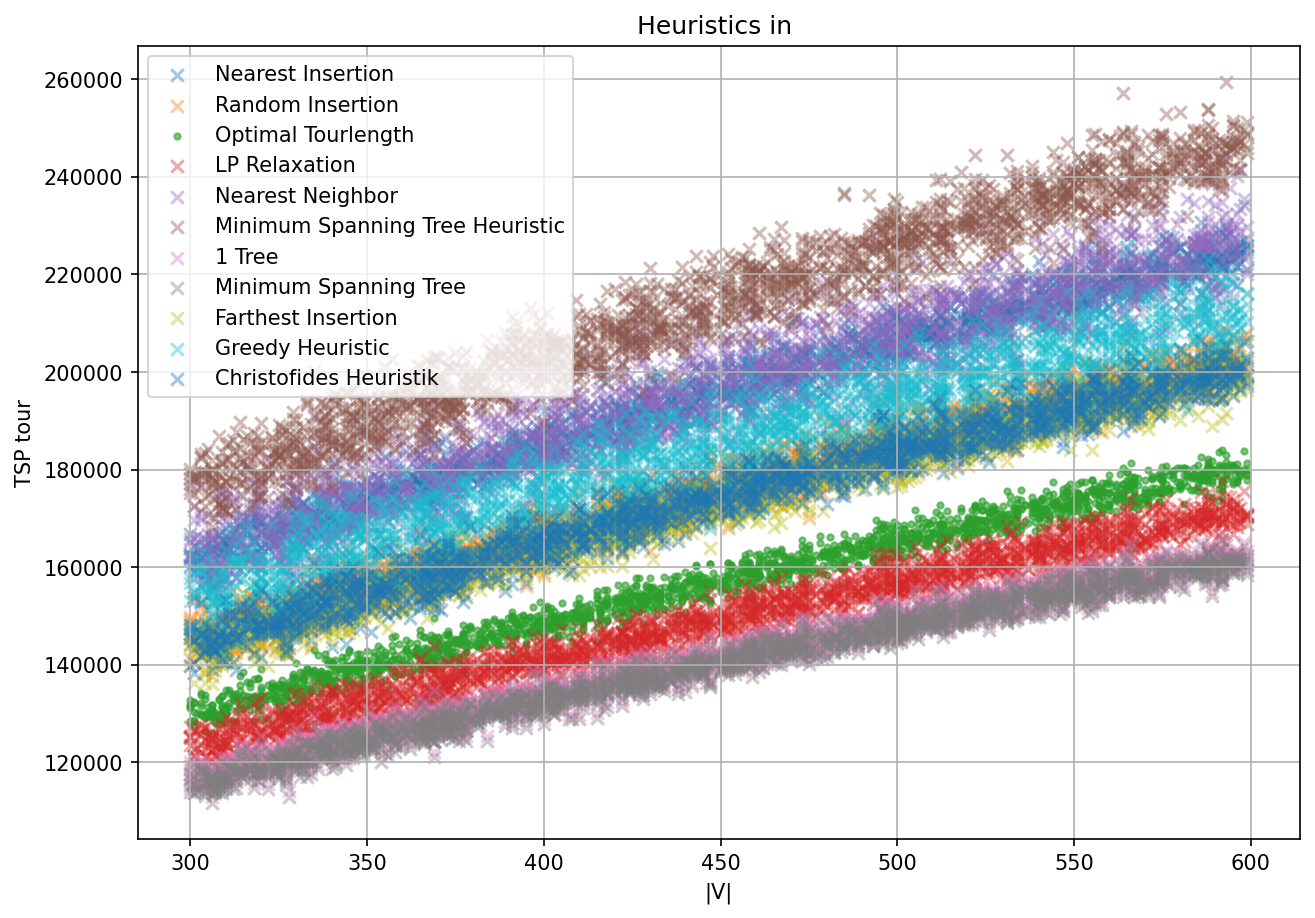

In [14]:
# plot the instance size /tour length distribution
plt.figure(figsize=(10, 7), dpi=150)

V = [len(x['node_coordinates']) for x in instances]

for (heuristic, data) in heuristics.items():
    if heuristic == 'opt':
        plt.scatter(V, data, marker='.', alpha=0.6, label=heuristic_names[heuristic])
    else:
        plt.scatter(V, data, marker='x', alpha=0.4, label=heuristic_names[heuristic])

plt.title('Heuristics in ')
plt.xlabel('|V|')
plt.ylabel('TSP tour')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
df_heuristics = pd.DataFrame(heuristics)

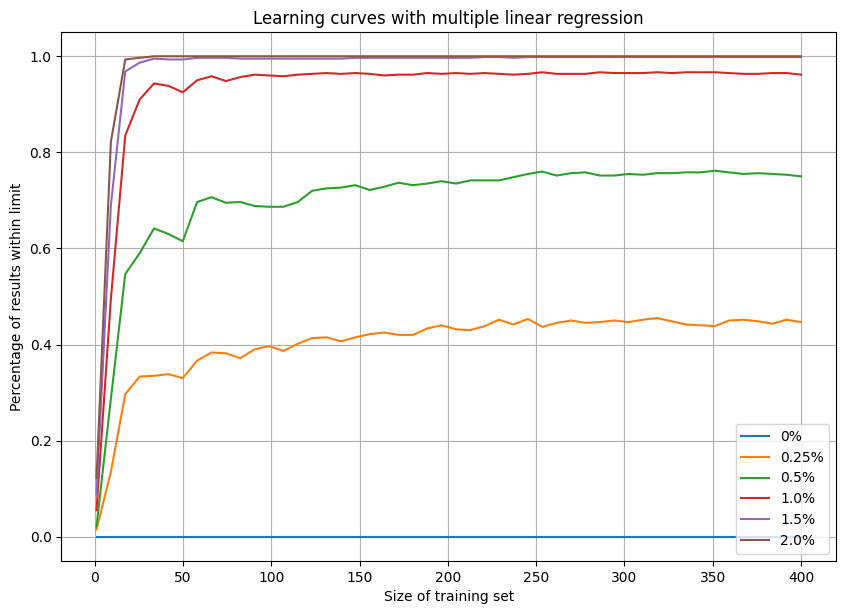

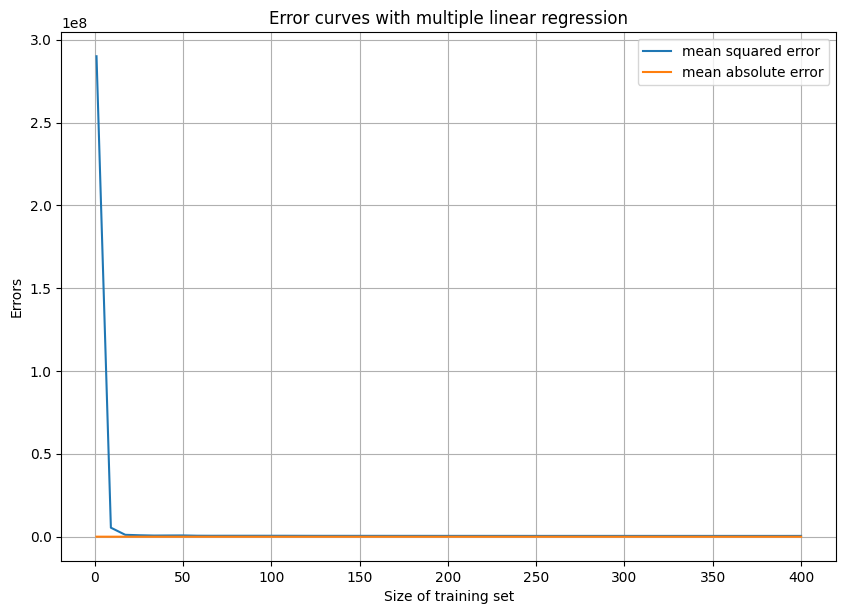

In [16]:
# splitting data
X = df_heuristics.drop(columns=['opt'])
y = df_heuristics['opt']

train_set_size = np.linspace(1, len(X)/5, num=50) / len(X)
results = {
    0: [],
    0.0025: [],
    0.005: [],
    0.01: [],
    0.015: [],
    0.02: [],
    'mean_squared_error': [],
    'mean_absolute_error':[]
}

for t in train_set_size:
    #creating training and test data
    X_train, X_verify, y_train, y_verify = train_test_split(
        X, y, train_size=t, test_size=0.3, random_state=101)

    # creating a regression model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # making predictions
    predictions = model.predict(X_verify)

    #adding devs
    results['mean_squared_error'].append(mean_squared_error(y_verify, predictions))
    results['mean_absolute_error'].append(mean_absolute_error(y_verify, predictions))

    for key, value in results.items():
        if isinstance(key, str):
            continue
        above_limit = np.array(predictions < (y_verify * (1+key)))
        under_limit = np.array(predictions > (y_verify * (1-key)))

        within_limits = np.logical_and(above_limit, under_limit)

        correct_predictions_rel = np.count_nonzero(within_limits)/len(X_verify)
        value.append(correct_predictions_rel)

#plotting the results
plt.figure(figsize=(10, 7), dpi=100)

for key, value in results.items():
    if not isinstance(key, str):
        plt.plot(train_set_size*len(X), value, label=str(key*100)+'%')

plt.title('Learning curves with multiple linear regression')
plt.xlabel('Size of training set')
plt.ylabel('Percentage of results within limit')
plt.grid(True)
plt.legend(loc='lower right')
plt.show()


plt.figure(figsize=(10, 7), dpi=100)

for key, value in results.items():
    if isinstance(key, str):
        plt.plot(train_set_size*len(X), value, label=key.replace('_',' '))

plt.title('Error curves with multiple linear regression')
plt.xlabel('Size of training set')
plt.ylabel('Errors')
plt.grid(True)
plt.legend(loc='upper right')
plt.show()